<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/machine-learning/Melvin_ml_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network by Hand

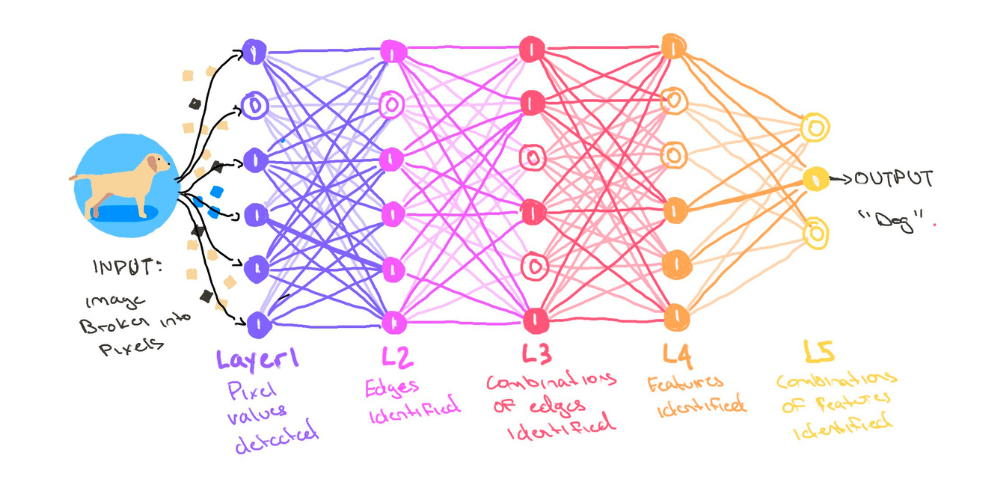

<a id="contents"></a>
# <p style="background-color: #265576; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">Table Of Contents</p>

<a id="setup"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px"> **A-Setup**</p>

<a id="mount"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">a.1. Mount the Google Drive in colab</p>

Mounting  Google Drive to Colab  allows us to access and save files directly from our Drive, making it easier to work with our data and projects.

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<a id="libraries"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">a.2. Installing Required Libraries</p>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys, os



For this turorial, we will be using the following libraries:
 - [`pandas`] for managing the data.
 - [`numpy`] for mathematical operations.
 - [`seaborn`] for visualizing the data.
 - [`matplotlib`] for visualizing the data.
 - ['os'] for management system

<a id="intro1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px"> Introduction</p>

In this tutorial, you will code a little neural network from scratch. Don’t worry, it will be extremely guided. The two most important points being that you learn and you have fun.


<a id="part1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">Part 0:The Math</p>

<a id="part1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">Part 1: Code Your Neural Network</p>

In [31]:
import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1

def predict(output_node, boundary_value):
    output_node = output_node.reshape(-1, 1, 1)
    predictions = (output_node > boundary_value).astype(int)
    return predictions

def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

    fig, ax = plt.subplots(figsize=(8, 6))
    iters = np.arange(1,len(train_costs)+1)
    ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
    ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
    ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
    ax.set_ylabel("Cost")
    ax.legend(loc="upper right", frameon=False)
    ax.set_title(title)
    plt.show()

def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

    # Create a grid of points spanning the parameter space:
    x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                           np.arange(range[0], range[1]+step, step)
    )

    # Stack it so that it is shaped like X_train: (m,2)
    X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

    # Feedforward on all grid points and get binary predictions:
    output = feedforward(X_grid, weights, biases)[-1] # getting only output node
    Ypred_grid = predict(output, boundary)

    return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None,
                 xname=XNAME, xlabel=XLABEL,
                 yname=YNAME, ylabel=YLABEL,
                 range=RANGE, step=STEP, title="Scatter plot"):

    fig, ax = plt.subplots()

    # Decision surface
    if ds:
        (xx, yy, Z) = ds # unpack contour data
        cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

    # Scatter signal and background:
    ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
    ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

    # Axes, legend and plot:
    ax.set_xlim(range); ax.set_xlabel(xlabel)
    ax.set_ylim(range); ax.set_ylabel(ylabel)

    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
    ax.set_title(title)
    plt.show()

<a id="data1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.1. Get the data</p>

In [32]:
df_train = pd.read_csv('/content/gdrive/MyDrive/intro_ML_data/ml_tutorial_5_data_train.csv')
df_test=pd.read_csv('/content/gdrive/MyDrive/intro_ML_data/ml_tutorial_5_data_test.csv')

<a id="data1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.1.1 Explore the data</p>

In [33]:
df_train.head(5)

,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
2,-4.147647,-0.226319,1
3,-2.170794,3.946986,0
4,-5.555908,1.155239,0


In [34]:
df_test.head(5)

,x1,x2,class
0,3.967433,5.580323,1
1,-5.324361,-4.574185,1
2,5.635016,3.301594,1
3,2.369043,-2.431812,0
4,3.607040,-3.598197,0


<a id="data1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.1.2 Split Signal vs Background</p>

In [35]:
sig = df_train.loc[df_train['class'] == 1, ['x1', 'x2']]
bkg = df_train.loc[df_train['class']==0,['x1','x2']]

<a id="plot1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.1.3 Dataframe to NumPy</p>

In [36]:
inputs = ['x1', 'x2']
X_train = df_train[inputs].to_numpy()
y_train = df_train['class'].to_numpy()

X_test = df_test[inputs].to_numpy()
y_test = df_test['class'].to_numpy()

In [37]:
print(X_train.shape)
print(X_test.shape)


(320, 2)
(80, 2)


<a id="function1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.2 Functions</p>

<a id="function1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.2.1 Weighted Sum</p>

In [38]:
def z(weights, inputs, bias):
    """
    Computes the weighted sum of inputs for a given activation unit.

    Parameters
    ----------
    weights : numpy.ndarray
        The weights of the activation unit.
    inputs : numpy.ndarray
        The input values to the activation unit.
    bias : float
        The bias of the activation unit.

    Returns
    -------
    float
        The weighted sum of inputs.
    """

    return weights.T @ inputs + bias

<a id="function1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.2.2 Activation Functions and Derivatives</p>

In [39]:
def tanh(z):
    return np.tanh(z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    s = sigmoid(z)
    return s * (1 - s)

def tanh_prime(z):
    return 1 - np.tanh(z)**2

<a id="function1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.2.3: Cross-entropy cost function</p>

In [40]:
def cross_entropy_cost(y_pred, y_true):
    """
    Computes the cross-entropy cost.

    Parameters
    ----------
    y_pred : numpy.ndarray
        The predicted values.
    y_true : numpy.ndarray
        The true values.

    Returns
    -------
    float
        The cross-entropy cost.
    """
    # Ensure y_true and y_pred have the same shape
    assert y_pred.shape == y_true.shape, "Shapes of y_pred and y_true must match"

    # Avoid log(0) by clipping predicted values
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute cross-entropy cost
    cost = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return cost

<a id="function1"></a>
# <p style="background-color: #1b907d; font-family:Avantgarde; color:#ffffff; font-size:150%; text-align:center; border-radius:200px 30px; overflow:hidden; padding:17px">1.2.4 Derivative of the Loss</p>

In [41]:
def L_prime(y_pred, y_true):
    """
    Computes the derivative of the cross-entropy loss function with respect to y_pred.

    Parameters
    ----------
    y_pred : numpy.ndarray
        The predicted values.
    y_true : numpy.ndarray
        The true values.

    Returns
    -------
    numpy.ndarray
        The derivative of the loss with respect to y_pred.
    """
    # Ensure y_true and y_pred have the same shape
    assert y_pred.shape == y_true.shape, "Shapes of y_pred and y_true must match"

    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    return -(y_true / y_pred) + (1 - y_true) / (1 - y_pred)

In [42]:
def feedforward(input_X, weights, biases):
    W1, W2, W3 = weights
    b1, b2, b3 = biases

    m  = len(input_X)
    a0 = input_X.reshape((m, -1, 1))

    # First layer
    z1 = z(W1, a0, b1)
    a1 = tanh(z1)

    # Second layer
    z2 = z(W2, a1, b2)
    a2 = tanh(z2)

    # Third layer
    z3 = z(W3, a2, b3)
    a3 = sigmoid(z3)

    nodes = [a0, z1, a1, z2, a2, z3, a3]
    return nodes



**What is the output_node in our 2-hidden-layer neural network?**

The `output_node` is the output of the final activation function (sigmoid in this case) in the third layer of the network. It represents the predicted probability of the positive class.

**What kind of values does predict return?**

The `predict` function returns binary values (0 or 1). It thresholds the output of the neural network at a specified `boundary_value` (default is 0.5) to make a class prediction.

**After running feedforward, how would you call predict to get predictions?**

After running `feedforward(input_X, weights, biases)` which returns a list of nodes, you would access the last element of this list (which is `a3`, the output layer) and pass it to the `predict` function along with the desired boundary value.


1.4 Neural Network Training

In [43]:
def print_every(iter_idx):
    if iter_idx <= 100:
        return iter_idx % 10 == 0
    elif iter_idx <= 1000:
        return iter_idx % 100 == 0
    else:
        return iter_idx % 1000 == 0

In [50]:
# Hyperparameters
alpha  = 0.05
n_iter = 5000

# Initialization
m = len(X_train)     # number of data samples
n = X_train.shape[1] # number of input features
q = 3 # number of nodes in first hidden layer
r = 2 # number of nodes in second hidden layer

# WEIGHT MATRICES + BIASES
W1 = np.random.random((n, q))
W2 = np.random.random((q, r))
W3 = np.random.random((r, 1))
b1 = np.random.random((q, 1))
b2 = np.random.random((r, 1))
b3 = np.random.random((1, 1))

weights = [W1, W2, W3]
biases  = [b1, b2, b3]


# OUTPUT LAYER
y_train = np.reshape(y_train, (-1, 1, 1))
y_test  = np.reshape(y_test , (-1, 1, 1))


# Storing cost values for train and test datasets
train_costs = []
test_costs  = []
debug = False

print("Starting the training\n")

# -------------------
#   Start iterations
# -------------------
for iter_idx in range(1, n_iter + 1):

    # FORWARD PROPAGATION
    # Feedforward on test data:
    nodes_test = feedforward(X_test, weights, biases)
    ypred_test = nodes_test[-1]

    # Feedforward on train data:
    a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train, weights, biases)
    ypred_train = a3

    # Cost computation and storage
    cost_train = cross_entropy_cost(ypred_train, y_train)
    cost_test  = cross_entropy_cost(ypred_test,  y_test)
    train_costs.append(cost_train)
    test_costs.append(cost_test)


    # BACKWARD PROPAGATION
    # Errors delta:
    delta_3 = sigmoid_prime(z3)*L_prime(ypred_train, y_train)
    delta_2 = tanh_prime(z2)*(W3 @ delta_3)
    delta_1 = tanh_prime(z1)*(W2 @ delta_2)

    # Partial derivatives
    dCostdW3 = np.mean(np.outer(a2, delta_3))
    dCostdW2 = np.mean(np.outer(a1, delta_2))
    dCostdW1 = np.mean(np.outer(a0, delta_1))

    dCostdb3 = np.mean(delta_3, axis=0)
    dCostdb2 = np.mean(delta_2, axis=0)
    dCostdb1 = np.mean(delta_1, axis=0)

# Print selected iterations
    if print_every(iter_idx):
        print(
            f"Iteration {iter_idx:>4}\t"
            f"Train cost: {cost_train:.5f}\t"
            f"Test cost: {cost_test:.5f}\t"
            f"Diff: {cost_test - cost_train:.2e}"
        )
    if debug and iter_idx < 3:
        print(
            f"Nodes: a0={a0.shape}, a1={a1.shape}, a2={a2.shape}, a3={a3.shape} | "
            f"Weights: W1={W1.shape}, W2={W2.shape}, W3={W3.shape} | "
            f"Gradients: dW1={dCostdW1.shape}, dW2={dCostdW2.shape}, dW3={dCostdW3.shape}"
        )

    # Update of weights and biases
    W3 = W3 - alpha * dCostdW3
    W2 = W2 - alpha * dCostdW2
    W1 = W1 - alpha * dCostdW1
    b3 = b3 - alpha * dCostdb3
    b2 = b2 - alpha * dCostdb2
    b1 = b1 - alpha * dCostdb1

    weights = [W1, W2, W3]
    biases = [b1, b2, b3]


print("\nFinished training")

Starting the training

Iteration   10	Train cost: 0.91289	Test cost: 0.94010	Diff: 2.72e-02
Iteration   20	Train cost: 0.89904	Test cost: 0.92853	Diff: 2.95e-02
Iteration   30	Train cost: 0.88748	Test cost: 0.91899	Diff: 3.15e-02
Iteration   40	Train cost: 0.87775	Test cost: 0.91106	Diff: 3.33e-02
Iteration   50	Train cost: 0.86952	Test cost: 0.90442	Diff: 3.49e-02
Iteration   60	Train cost: 0.86248	Test cost: 0.89879	Diff: 3.63e-02
Iteration   70	Train cost: 0.85639	Test cost: 0.89397	Diff: 3.76e-02
Iteration   80	Train cost: 0.85107	Test cost: 0.88976	Diff: 3.87e-02
Iteration   90	Train cost: 0.84635	Test cost: 0.88602	Diff: 3.97e-02
Iteration  100	Train cost: 0.84211	Test cost: 0.88264	Diff: 4.05e-02
Iteration  200	Train cost: 0.81040	Test cost: 0.85482	Diff: 4.44e-02
Iteration  300	Train cost: 0.78086	Test cost: 0.82370	Diff: 4.28e-02
Iteration  400	Train cost: 0.75339	Test cost: 0.79243	Diff: 3.90e-02
Iteration  500	Train cost: 0.73238	Test cost: 0.76760	Diff: 3.52e-02
Iteration  

1.5 Plots

1.5.1 Cost evolution

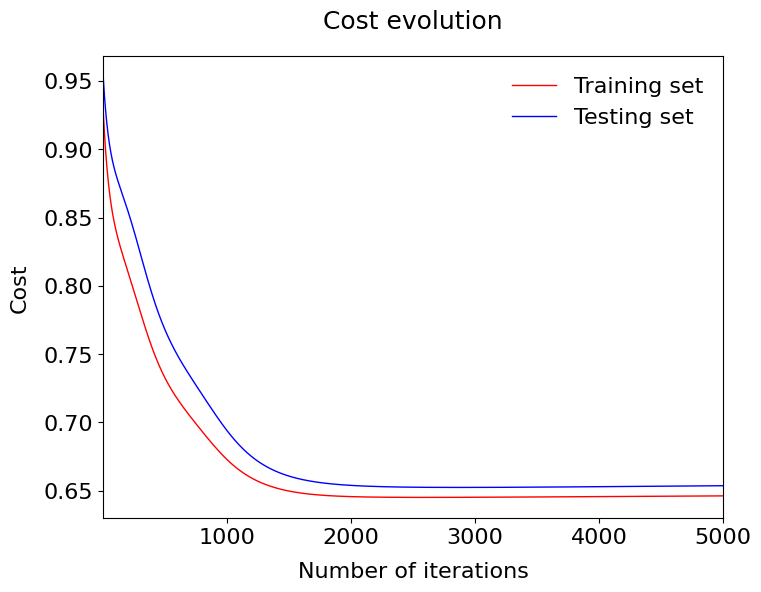

In [51]:
plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution")

1.5.2 Scatter Plot

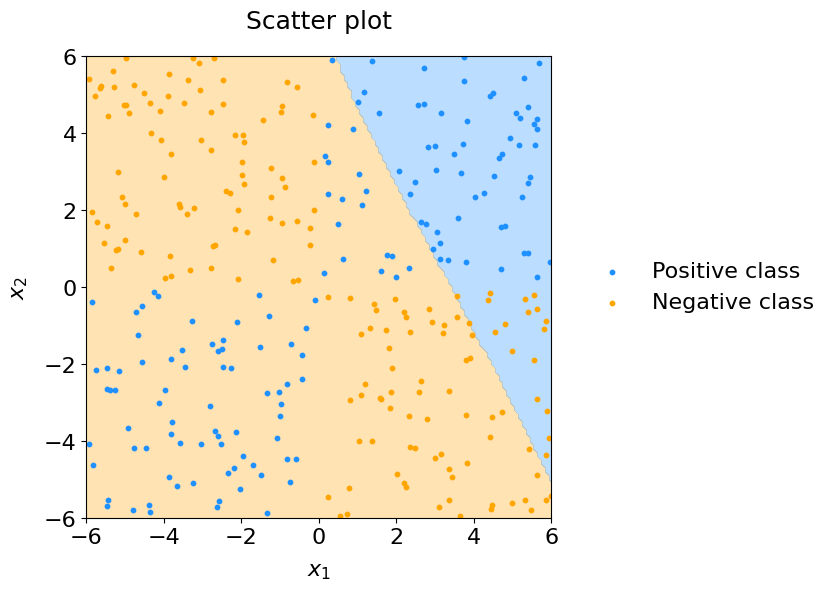

In [52]:
ds=get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP)
plot_scatter(sig, bkg, ds=ds,
                 xname=XNAME, xlabel=XLABEL,
                 yname=YNAME, ylabel=YLABEL,
                 range=RANGE, step=STEP, title="Scatter plot")
